In [34]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point, Polygon, shape
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import io
from PIL import Image
import requests
from io import BytesIO
import os
import pickle
from tqdm import tqdm
import dpkt
# from Utils import get_foreground_point_cloud
from LiDARBase import parse_one_packet,calc_precise_azimuth,laser_id,Data_order,arg_omega,calc_timing_offsets,get_foreground_point_cloud
from Utils import *
from GenBckFile import *

In [29]:
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    print(Timestamp)
    next_ts = Timestamp + 100000 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = self.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if Timestamp > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 100000
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [30]:
Td_maps = []
pcap_file_path = r'D:\LiDAR_Data\9thVir\2024-03-24-23-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)

for Td_map in tqdm(td_gen):
    Td_maps.append(Td_map)

4it [00:00, 35.33it/s]

1801103342


17988it [07:53, 37.95it/s] 


In [31]:

background_data = np.array(Td_maps)
thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)         

100%|██████████| 32/32 [00:52<00:00,  1.64s/it]


In [10]:
np.save('./thred_map.npy',thred_map)
thred_map = np.load('./thred_map.npy')

In [32]:
bck_radius = 0.2
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()

Lane zone updated


In [42]:
data_raw

array([], shape=(0, 2), dtype=float64)

In [35]:
lane_ind = 6
count_thred = 3
test_time_space_series = []
for Td_map in tqdm(Td_maps):
    
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                            Td_map,vertical_limits)
    if len(data_raw) == 0:
        test_time_space_series.append(np.zeros(len(lane_section_foreground_point_counts[lane_ind])))
        continue
    lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                lane_drawer.lane_gdf,
                                                                                data_raw,point_labels)
    opccupation_counts = np.array(lane_section_foreground_point_counts[lane_ind])
    opccupation_ind_map = opccupation_counts > count_thred
    test_time_space_series.append(opccupation_ind_map) 
test_time_space_series = np.array(test_time_space_series)

 78%|███████▊  | 14093/17988 [15:20<04:14, 15.30it/s]


AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

In [46]:
def get_merged_activation(activation_start,activation_end,lane_activation):
    lane_activation = lane_activation.copy()
    activation_start,activation_end = find_concecutive_activation(lane_activation)
    for i in range(1,len(activation_end)):
        if activation_start[i] - activation_end[i-1] < 6:
            lane_activation[activation_end[i-1]:activation_start[i]] = True
    return lane_activation
def find_concecutive_activation(activation):
    activation_start = []
    activation_end = []
    activation_flag = False
    for i in range(len(activation)):

        if activation[i] == True and activation_flag == False:
            activation_start.append(i)
            activation_flag = True
        elif activation[i] == False and activation_flag == True:
            activation_end.append(i)
            activation_flag = False
    return activation_start,activation_end

In [97]:
total_queue = []
for i in tqdm(range(test_time_space_series.shape[0] - 1)):
    lane_activation_cur = test_time_space_series[i,:]
    lane_activation_next = test_time_space_series[i+1,:]

    activation_start,activation_end = find_concecutive_activation(lane_activation_cur)
    lane_activation_cur_ = get_merged_activation(activation_start,activation_end,lane_activation_cur)
    activation_start,activation_end = find_concecutive_activation(lane_activation_next)
    lane_activation_next_ = get_merged_activation(activation_start,activation_end,lane_activation_next)

    # the end activation is actually at the location of front of the vehicle
    _,activation_end_cur = find_concecutive_activation(lane_activation_cur_)
    _,activation_end_next = find_concecutive_activation(lane_activation_next_)
    activation_end_cur = np.array(activation_end_cur)
    activation_end_next = np.array(activation_end_next)
    # so we need an association between the two activations linear sum assignment, the constraint is that the distance between two activations should be less than 1m
    # we need to calculate the cost matrix
    # if either activation_end is 0, total_queue append 0
    if len(activation_end_cur) == 0 or len(activation_end_next) == 0:
        total_queue.append(0)
        continue
    cost_matrix = np.zeros((len(activation_end_cur),len(activation_end_next)))
    for i in range(len(activation_end_cur)):
        for j in range(len(activation_end_next)):
            dis = np.abs(activation_end_cur[i] - activation_end_next[j]) * 0.5
            if dis > 3:
                cost_matrix[i,j] = 1000
            else:
                cost_matrix[i,j] = dis
            
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize = False)
    # calculate the speed
    speeds = []
    for i in range(len(row_ind)):
        speed = np.abs(activation_end_cur[row_ind[i]] - activation_end_next[col_ind[i]]) * 0.5
        if speed > 3:
            speed = 0
        speeds.append(speed)
    speeds = np.array(speeds)
    # if speed is lower than 5km/h, we consider it as a queue
    queue = (speeds < 5).sum()
    # queue = (test_time_space_series.shape[1] - activation_end_cur[row_ind[speeds < 5]].min()) * 0.5
    # find the farthest queue
    total_queue.append(queue)

100%|██████████| 14092/14092 [00:19<00:00, 715.91it/s]


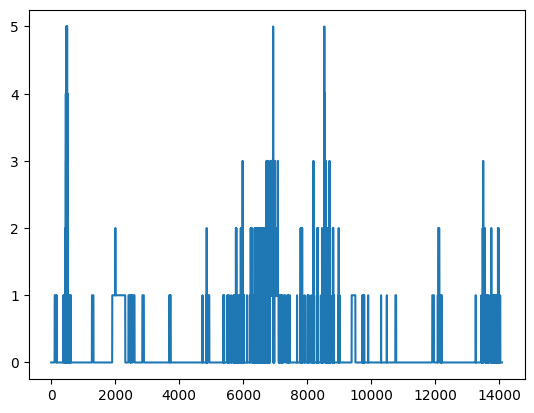

In [98]:
# plot the queue length
plt.plot(total_queue)
# plt.xlim(0,600)
plt.show()

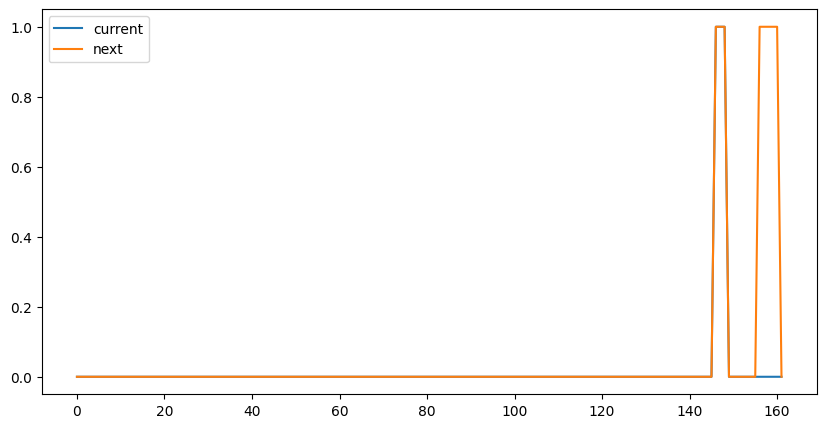

In [105]:
plt.figure(figsize=(10,5))
# 0.5 meter section length
plt.plot(lane_activation_cur_,label = 'current')
# plt.plot(lane_activation_cur)
plt.plot(lane_activation_next_,label = 'next')
plt.legend()

# plt.xlim(120,130)
plt.show()

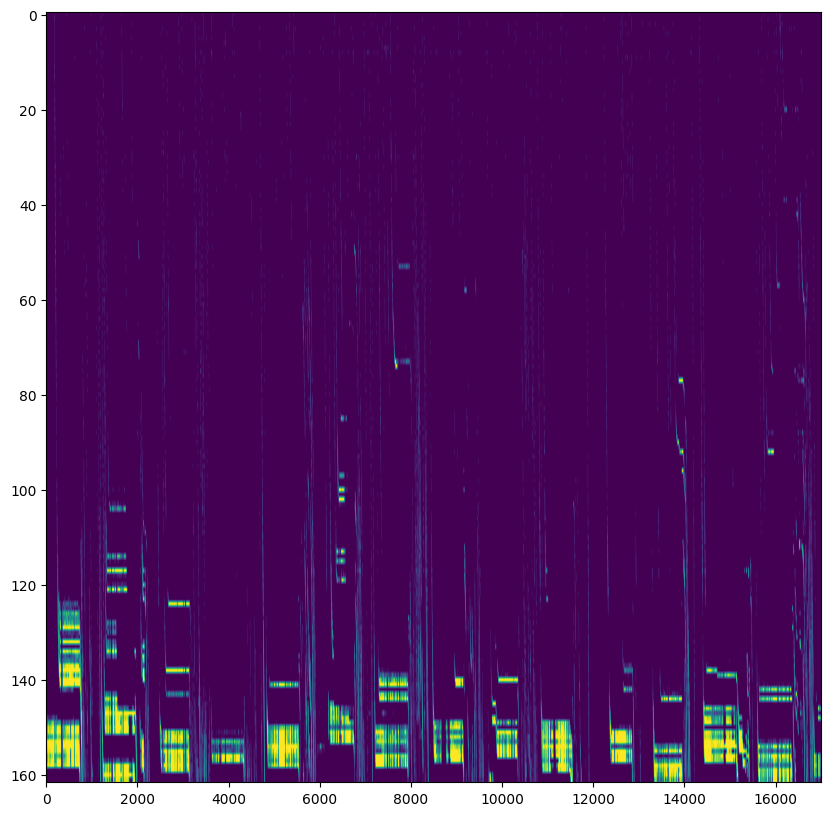

In [106]:
plt.figure(figsize = (10,10))
plt.imshow(test_time_space_series.T,aspect = 'auto')
# plt.ylim(140,160)
# plt.xlim(0,180)
plt.show()

In [178]:
test_lane_poly = lane_subsections_poly[0] # END poly is the stop bar

In [172]:
pdf = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(lane_subsections_poly[0]))

In [175]:
pdf['id'] = np.arange(len(pdf))